#Audio Classification¶
https://www.youtube.com/watch?v=Cf6QFjdU_KY&list=PL7ZVZgsnLwEGskuPmm2-pYsNKY8Ihs5AP&index=2

In [1]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

In [2]:
midi_file = "/content/drive/MyDrive/GeneralMidi.wav"

# amplitude, sr = librosa.load(midi_file)

In [3]:
# librosa.display.waveplot(amplitude, sr=sr)      # 소리 데이터를 그래프로 표현하기
# plt.title('Waveplot')                   # 그래프 제목 설정하기   
# plt.show()  

In [4]:
instruments = [0, 10 ,20, 30, 40, 50, 60, 70, 80, 90]
num_notes = 50
sec = 2 # 2초 간격으로 원본 데이터에 들어있음

audio = []
inst = []
for idx, note in itertools.product(range(len(instruments)), range(num_notes)): # len(instruments)를 numnotes만큼 반복
  instrument = instruments[idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print('instrument:{}, note:{}, offset:{}'.format(instrument, note, offset))
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(idx)

instrument:0, note:0, offset:0
instrument:0, note:1, offset:2
instrument:0, note:2, offset:4
instrument:0, note:3, offset:6
instrument:0, note:4, offset:8
instrument:0, note:5, offset:10
instrument:0, note:6, offset:12
instrument:0, note:7, offset:14
instrument:0, note:8, offset:16
instrument:0, note:9, offset:18
instrument:0, note:10, offset:20
instrument:0, note:11, offset:22
instrument:0, note:12, offset:24
instrument:0, note:13, offset:26
instrument:0, note:14, offset:28
instrument:0, note:15, offset:30
instrument:0, note:16, offset:32
instrument:0, note:17, offset:34
instrument:0, note:18, offset:36
instrument:0, note:19, offset:38
instrument:0, note:20, offset:40
instrument:0, note:21, offset:42
instrument:0, note:22, offset:44
instrument:0, note:23, offset:46
instrument:0, note:24, offset:48
instrument:0, note:25, offset:50
instrument:0, note:26, offset:52
instrument:0, note:27, offset:54
instrument:0, note:28, offset:56
instrument:0, note:29, offset:58
instrument:0, note:30, of

In [5]:
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16) 

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


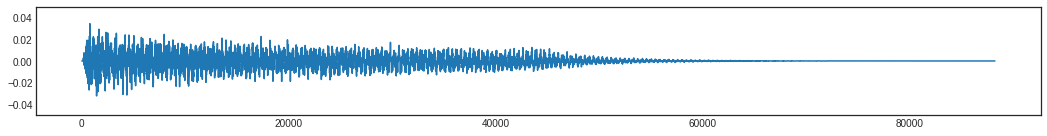

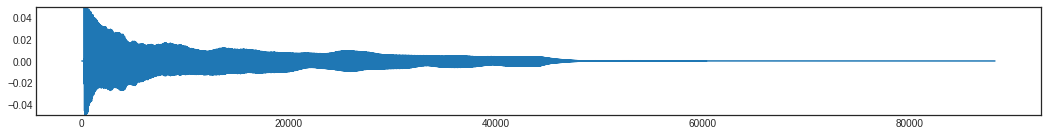

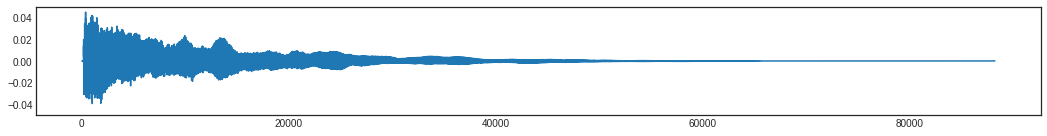

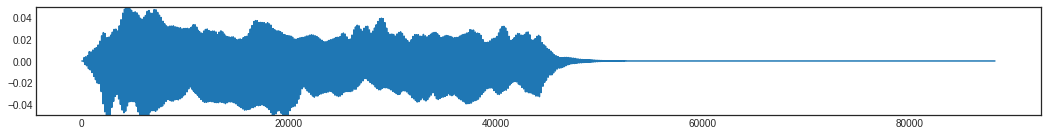

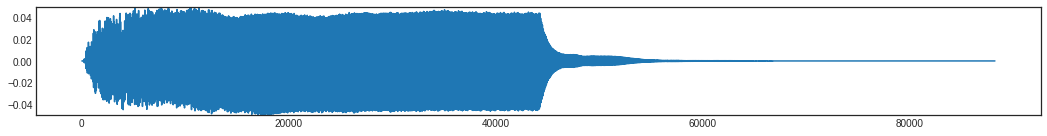

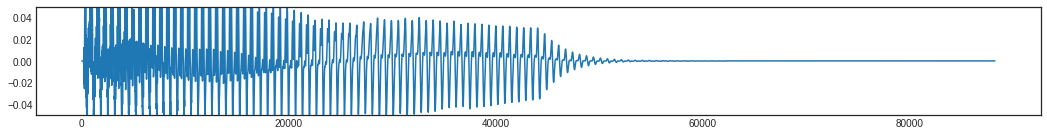

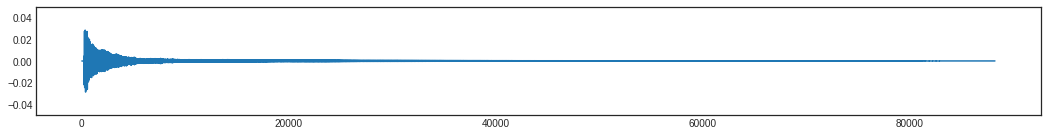

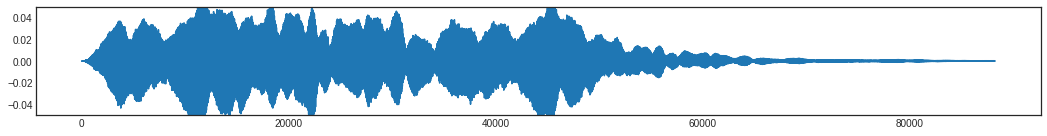

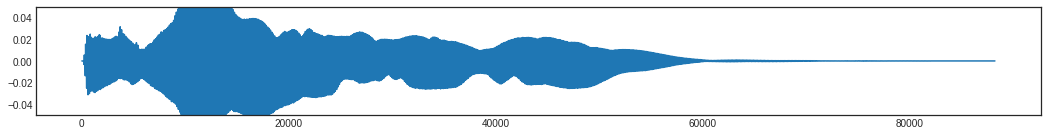

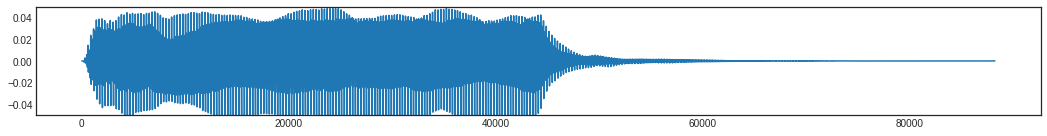

In [6]:
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim((-0.05, 0.05))
  plt.show()

In [7]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [8]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # 스케일 조정 정규화 함수로 모든 데이터가 0과 1사이의 값을 갖도록 해준다.
scaler.fit(audio_np)

MinMaxScaler()

# 머신러닝을 통한 오디오 분류劉

In [10]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 88200)
(100, 88200)
(400,)
(100,)


# Logistic Regression
-> logistic regression은 binary problem에 적합하지 다중 분류에는 적합하지 않음. 따라서 여기서는 적합한 모델이 아님.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.06


# Support Vector Machine


In [12]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.07


# Decision Tree


In [13]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.37


## 데이터를 가공해서 정확도를 올려야 함

1. wav 파일은 음압을 저장한 형태여서 음악을 분석하기에 적합하지 않음
2. 푸리에 변환 또는 Constant-Q 변환을 통해 주파수 축의 데이터로 바꿔야 함

Constant-Q 변환에는 `librosa.cqt`를 사용

`n_bins` : 옥타브 단계 및 개수, `bins_per_octave` : 한 옥타브가 가지는 단계

In [14]:
audio_cqt = []

for y in audio:
  ret = librosa.cqt(y, sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


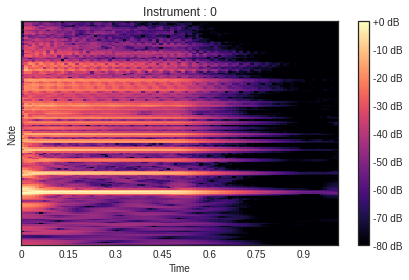

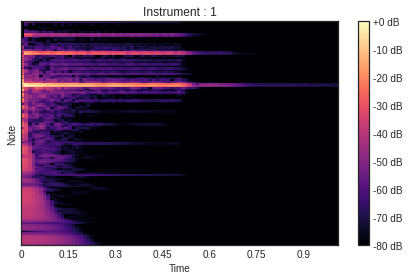

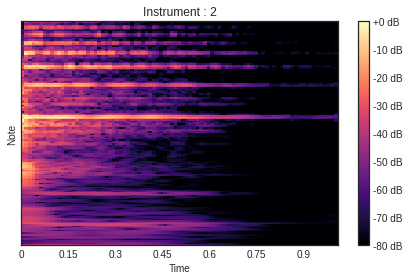

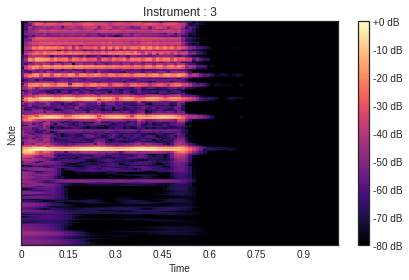

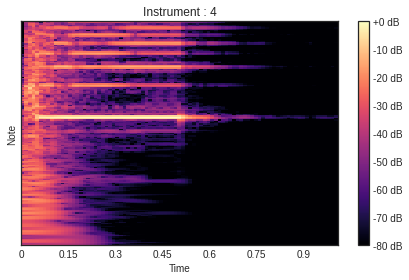

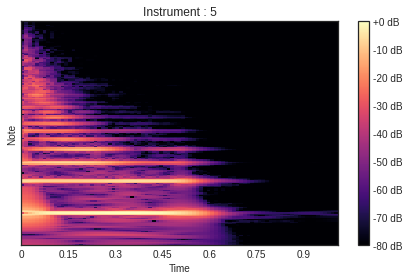

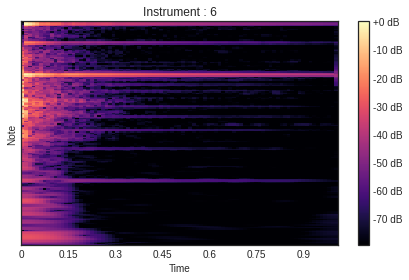

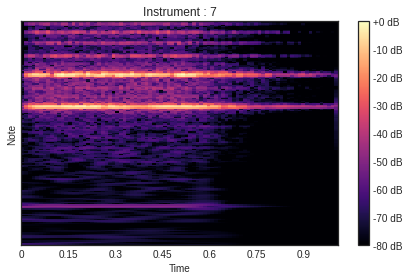

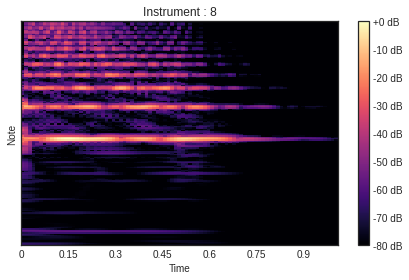

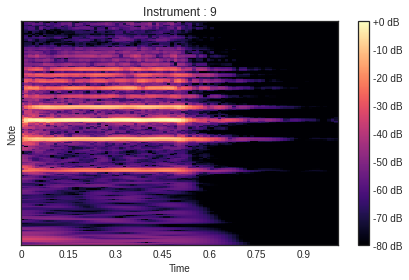

In [15]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument : {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [16]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)


현재 3차원 벡터이므로 이를 2차원 벡터로 바꿔야 분류기에서 사용할 수 있음.

In [17]:
cqt_np = cqt_np.reshape((500, 168 * 87))

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

In [19]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616)
(100, 14616)
(400,)
(100,)


# Logistic Regression
-> logistic regression은 binary problem에 적합하지 다중 분류에는 적합하지 않음. 따라서 여기서는 적합한 모델이 아님.


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.27


# Support Vector Machine


In [21]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.29


# Decision Tree


In [22]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.63


# Constant-Q 특징을 이용한 딥러닝 오디오 분류


In [23]:
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500, 168*87))
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

print(inst_cat)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(400, 14616, 1)
(100, 14616, 1)
(400, 10)
(100, 10)


In [24]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(14616,), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer ='adam',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
  return model

In [25]:
model = model_build()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14616)]           0         
                                                                 
 hidden1 (Dense)             (None, 512)               7483904   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 7,649,418
Trainable params: 7,649,418
Non-trainable params: 0
_________________________________________________________________


In [26]:
hist = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 3s 98ms/step - loss: 2.2383 - acc: 0.1219 - val_loss: 2.1563 - val_acc: 0.1500
Epoch 2/30
3/3 [==============================] - 0s 19ms/step - loss: 1.8891 - acc: 0.4750 - val_loss: 2.0679 - val_acc: 0.1500
Epoch 3/30
3/3 [==============================] - 0s 19ms/step - loss: 1.5789 - acc: 0.5938 - val_loss: 1.9404 - val_acc: 0.2375
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 1.2600 - acc: 0.6219 - val_loss: 1.7734 - val_acc: 0.2125
Epoch 5/30
3/3 [==============================] - 0s 21ms/step - loss: 1.0088 - acc: 0.6938 - val_loss: 1.7408 - val_acc: 0.2250
Epoch 6/30
3/3 [==============================] - 0s 21ms/step - loss: 0.8127 - acc: 0.7719 - val_loss: 1.8618 - val_acc: 0.2375
Epoch 7/30
3/3 [==============================] - 0s 19ms/step - loss: 0.6494 - acc: 0.8313 - val_loss: 1.9312 - val_acc: 0.2500
Epoch 8/30
3/3 [==============================] - 0s 18ms/step - loss: 0.5289 - acc: 0.8750 - val

In [27]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  loss = history_dict['acc']
  val_loss = history_dict['val_acc']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, loss, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_loss, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()



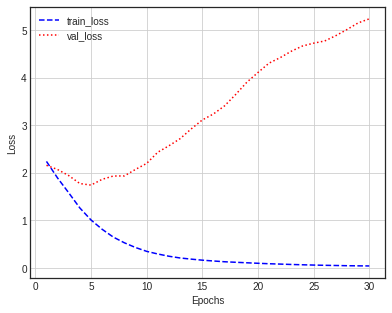

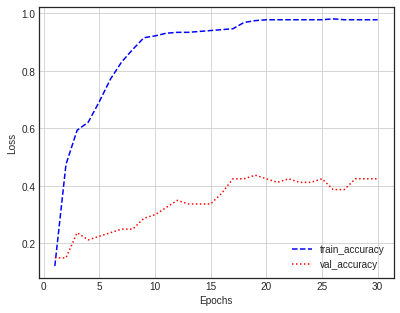

In [28]:
plot_history(hist.history)

In [29]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 6ms/step - loss: 5.4825 - acc: 0.4200


[5.482471942901611, 0.41999998688697815]

## CNN 방법으로 처리해보기

In [30]:
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [31]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential

  input = Input(shape=(168,87,1))

  output = Conv2D(128,3,strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)


  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer ='adam',
               loss = 'categorical_crossentropy',
               metrics=['acc'])
  return model


In [32]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 87, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 168, 87, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 44, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 44, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 22, 512)       1180

In [33]:
hist = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 17s 2s/step - loss: 2.2417 - acc: 0.1344 - val_loss: 1.9570 - val_acc: 0.2625
Epoch 2/20
3/3 [==============================] - 1s 258ms/step - loss: 1.7751 - acc: 0.3594 - val_loss: 1.4339 - val_acc: 0.3875
Epoch 3/20
3/3 [==============================] - 1s 261ms/step - loss: 1.1991 - acc: 0.5406 - val_loss: 1.2766 - val_acc: 0.4875
Epoch 4/20
3/3 [==============================] - 1s 260ms/step - loss: 0.8664 - acc: 0.6969 - val_loss: 1.0940 - val_acc: 0.5875
Epoch 5/20
3/3 [==============================] - 1s 258ms/step - loss: 0.6847 - acc: 0.7750 - val_loss: 1.0386 - val_acc: 0.6625
Epoch 6/20
3/3 [==============================] - 1s 262ms/step - loss: 0.4838 - acc: 0.8562 - val_loss: 0.7414 - val_acc: 0.8000
Epoch 7/20
3/3 [==============================] - 1s 263ms/step - loss: 0.4183 - acc: 0.9031 - val_loss: 0.3887 - val_acc: 0.8875
Epoch 8/20
3/3 [==============================] - 1s 262ms/step - loss: 0.2529 - acc: 0.9438

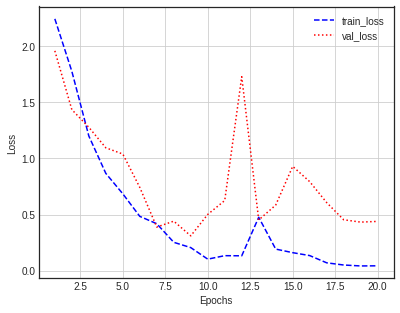

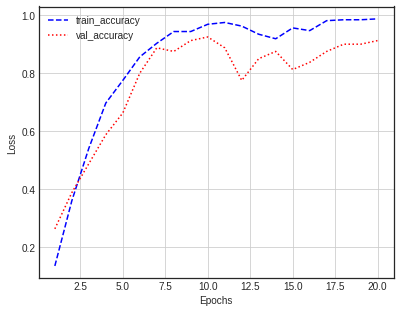

In [34]:
plot_history(hist.history)

In [35]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 1s 65ms/step - loss: 0.7038 - acc: 0.8600


[0.7037756443023682, 0.8600000143051147]